<a href="https://colab.research.google.com/github/lucavillela/fuzzy-heartbeat-diagnosis/blob/main/fuzzyDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install scikit-fuzzy

# **Implementação de métodos Fuzzy na classificação de batimentos cardíacos**

- com uso da biblioteca:
https://scikit-fuzzy.github.io/scikit-fuzzy/overview.html

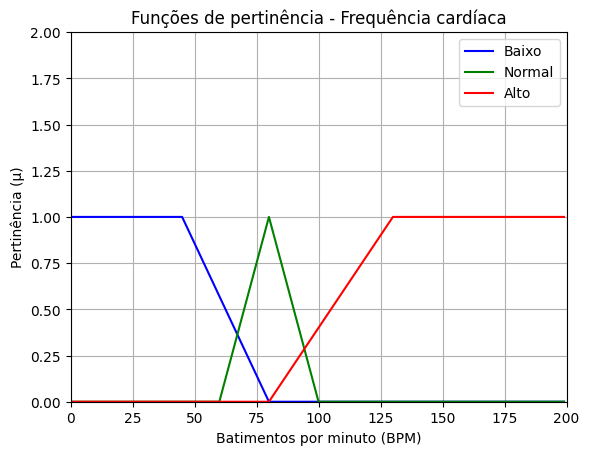

In [26]:
import skfuzzy as fuzz
import numpy as np
import random
import matplotlib.pyplot as plt

heart_beats = np.arange(0, 200, 1) # intervalo em que podem existir BPM's
'''
usei também trapezoidal, para garantir que valores abaixo do mínimo e acima do
máximo fossem classificados respectivamente como baixo e alto.
'''
baixo = fuzz.trapmf(heart_beats, [0, 0, 45, 80])
normal = fuzz.trimf(heart_beats, [60, 80, 100])
alto = fuzz.trapmf(heart_beats, [80, 130, 200, 200])

#visualização das nossas funçoes de pertinencias genéricas
plt.plot(heart_beats, baixo, 'b', label='Baixo')
plt.plot(heart_beats, normal, 'g', label='Normal')
plt.plot(heart_beats, alto, 'r', label='Alto')
plt.title('Funções de pertinência - Frequência cardíaca')
plt.xlabel('Batimentos por minuto (BPM)')
plt.ylabel('Pertinência (μ)')
plt.legend()
plt.xlim(0, 200)
plt.ylim(0, 2)
plt.grid(True)
plt.show()




# **Aplicação no cenário do projeto de DLP**
- 3 grupos de idades diferentes, cada um com suas funções
- Diagnóstico final para os 3 grupos, dado um bpm parâmetro

### **Parte 01 - implementação do método fuzzy adaptado**

In [27]:
heart_beats = np.arange(0, 200, 1)

#dicionario com os intervalos normais para cada grupo de idade
pacientes = {'crianca':
                {'min': 80, 'max': 120},
             'adulto':
                {'min': 60, 'max': 100},
             'idoso':
                {'min': 60, 'max': 90}
             }
defasagem = 20 # determina a intensidade da intersseção entre as classes (ver com prof)

#função que gera as funções de pertinência para cada grupo
def gerar_funcoes_pert():
  funcoes = {}
  for tipo, valores in pacientes.items():
    mn = valores['min']
    mx = valores['max']
    mid = (mn + mx)/2
    funcoes[tipo] = {
        'baixo': fuzz.trapmf(heart_beats, [0, 0, (mn - defasagem), mid]),
        'normal': fuzz.trimf(heart_beats, [mn, mid, mx]),
        'alto': fuzz.trapmf(heart_beats, [mid, mx + defasagem, 200, 200])
    }
  return funcoes

funcoes_pert = gerar_funcoes_pert()

# função final que dá o diagnóstico com base nas funções de pertinencia por grupo
def diagnostico(bpm):
  resultado = {}
  for tipo, valores in funcoes_pert.items():
        baixo = fuzz.interp_membership(heart_beats, valores['baixo'], bpm)
        normal = fuzz.interp_membership(heart_beats, valores['normal'], bpm)
        alto = fuzz.interp_membership(heart_beats, valores['alto'], bpm)

        grupo = {
            'baixo': round(float(baixo), 2),
            'normal': round(float(normal), 2),
            'alto': round(float(alto), 2)
        }
        if grupo['normal'] >= 0.3: #adiciona um bias para resultado ser normal
            diag = 'normal'
        else:
          diag = max(grupo, key=grupo.get)

        grupo['diagnostico'] = diag
        resultado[tipo] = grupo

  return resultado


### **Parte 02 - detecção de batimentos cardiacos**
- contagem de BPM feita através de leitura de dataset de ECG
- dataset disponível em: https://www.kaggle.com/datasets/shayanfazeli/heartbeat

In [28]:
import pandas as pd
import math

df = pd.read_csv('ecg_dataset.csv', header=None)

def cicles_between_spikes(ecg):
  allow_count = False
  count = 0
  for signal in ecg:
    if signal > 0.85: #pico detectado?
      if allow_count and count > 3: #pico já detectado e mais de 3 ciclos já se passaram?
        break # achou-se então o segundo pico e a contagem foi concluida
      allow_count = True # achou o primeiro pico, então pode contar
    if allow_count:
      count += 1 # conta se puder contar
  return count

def convert_cicles_to_bpm(cicles, freq=125):
  period_sec = cicles / freq
  return math.floor(60 / period_sec)

def bpm_array_n(n):
    '''
      A título de demonstração, essa função pega n amostras de exame ECG aleatórias
      no dataset e as converte em um array com os BPMs já convertidos.
    '''
    beats = []
    random_indices = random.sample(range(len(df)), n)
    for idx in random_indices:
        ecg = df.iloc[idx].tolist()
        bpm = convert_cicles_to_bpm(cicles_between_spikes(ecg))
        beats.append(bpm)
    return beats

### **Demonstração em código**
- Nessa demonstração será exibido um diagnóstico por bpm extraído do dataset por grupo etário definido (criança, adulto, idoso).
- Faz-se os 3 diagnósticos pois não se tem o dado "idade" por amostra.
- Além do diagnóstico é exibido também a taxa de pertencimento a cada possível resultado: baixo, normal ou alto.

In [29]:
import json

bpm_array = bpm_array_n(5) # define quantas amostras se quer exibir o diagnóstico
bpm_dict = {}

for bpm in bpm_array:
  bpm_dict[bpm] = diagnostico(bpm)

print(json.dumps(bpm_dict, indent=2, ensure_ascii=False))

{
  "74": {
    "crianca": {
      "baixo": 0.65,
      "normal": 0.0,
      "alto": 0.0,
      "diagnostico": "baixo"
    },
    "adulto": {
      "baixo": 0.15,
      "normal": 0.7,
      "alto": 0.0,
      "diagnostico": "normal"
    },
    "idoso": {
      "baixo": 0.03,
      "normal": 0.93,
      "alto": 0.0,
      "diagnostico": "normal"
    }
  },
  "60": {
    "crianca": {
      "baixo": 1.0,
      "normal": 0.0,
      "alto": 0.0,
      "diagnostico": "baixo"
    },
    "adulto": {
      "baixo": 0.5,
      "normal": 0.0,
      "alto": 0.0,
      "diagnostico": "baixo"
    },
    "idoso": {
      "baixo": 0.43,
      "normal": 0.0,
      "alto": 0.0,
      "diagnostico": "baixo"
    }
  },
  "72": {
    "crianca": {
      "baixo": 0.7,
      "normal": 0.0,
      "alto": 0.0,
      "diagnostico": "baixo"
    },
    "adulto": {
      "baixo": 0.2,
      "normal": 0.6,
      "alto": 0.0,
      "diagnostico": "normal"
    },
    "idoso": {
      "baixo": 0.09,
      "normal": 0.8